<a href="https://www.kaggle.com/code/vedatgul/demand-forecasting-sales-prediction-with-minimal?scriptVersionId=265054312" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 📊 Demand Forecasting — Sales Prediction with Minimal Features

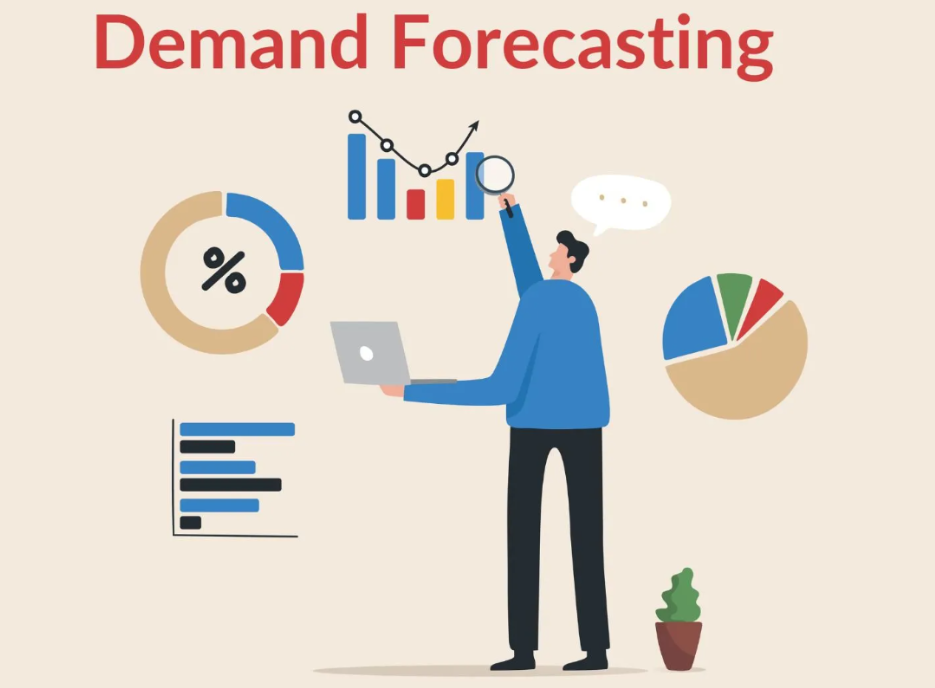

Accurately predicting product demand is one of the most critical tasks for businesses in retail, logistics, and supply chain management. This notebook demonstrates how to build a **sales forecasting model** using a **minimal set of features**, focusing on temporal and categorical data, while still achieving competitive results.

### 🚀 Key Highlights

* **Feature Engineering:** Extracted time-based features such as month, day of week, week of year, and indicators for weekends and month boundaries.
* **Handling Categorical Variables:** One-hot encoding applied for store, item, and weekday information to enhance model performance.
* **Modeling Approach:** LightGBM, a high-performance gradient boosting framework, is used for regression on log-transformed sales data.
* **Evaluation Metric:** SMAPE (Symmetric Mean Absolute Percentage Error) is employed to measure prediction accuracy.
* **Minimalistic Design:** Focused on keeping the feature set small while capturing the most predictive signals, making the model fast and easy to interpret.

### 🔍 Notebook Goals

1. Show how to efficiently preprocess and engineer temporal features for demand forecasting.
2. Train a LightGBM regression model with minimal features.
3. Evaluate model performance using SMAPE and interpret results.
4. Provide a clean, easy-to-follow pipeline for beginners and intermediate practitioners.

Whether you are a data science enthusiast or a professional working on retail sales forecasting, this notebook provides a **concise, practical, and reproducible approach** to predicting product demand with minimal complexity.


In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [3]:
########################
# Loading the data
########################

train = pd.read_csv('/kaggle/input/demand-forecasting-app/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/demand-forecasting-app/test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('/kaggle/input/demand-forecasting-app/sample_submission.csv')

df = pd.concat([train, test], sort=False)

In [4]:
#####################################################
# EDA
#####################################################

df["date"].min(), df["date"].max()

check_df(df)

df[["store"]].nunique()

df[["item"]].nunique()

df.groupby(["store"])["item"].nunique()

df.groupby(["store", "item"]).agg({"sales": ["sum"]})

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

df.head()

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [5]:
#####################################################
# FEATURE ENGINEERING
#####################################################

# Tarih özelliklerini oluşturma fonksiyonu
def create_date_features(df):
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week  # Deprecated uyarısı yok
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df['is_wknd'] = (df['date'].dt.dayofweek >= 5).astype(int)  # Cumartesi-Pazar = 1
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    return df

# Özellikleri ekle
df = create_date_features(df)

# Store, item ve month bazında satışların özet istatistikleri
agg_df = df.groupby(['store', 'item', 'month'])['sales'].agg(['sum', 'mean', 'median', 'std']).reset_index()

# İlk 5 satırı kontrol et
agg_df.head()


,store,item,month,sum,mean,median,std
0,1,1,1,2125.0,13.709677,13.0,4.397413
1,1,1,2,2063.0,14.631206,14.0,4.668146
2,1,1,3,2728.0,17.600000,17.0,4.545013
3,1,1,4,3118.0,20.786667,20.0,4.894301
4,1,1,5,3448.0,22.245161,22.0,6.564705


In [6]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [7]:
########################
# Lag/Shifted Features
########################

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

df.groupby(["store", "item"])['sales'].head()

df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int64
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [8]:
########################
# Rolling Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})


def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

In [9]:

########################
# Exponentially Weighted Mean Features
########################

pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

In [10]:

# Apply one-hot encoding to categorical columns
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'], dtype=int)

# Check the DataFrame to ensure it's ready for analysis
check_df(df)

# Select only numeric columns for quantile calculation
numeric_df = df.select_dtypes(include='number')

# Calculate quantiles for numeric columns
quantiles = numeric_df.quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T
print(quantiles)


##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int32
day_of_year              int32
                     ...      
month_8                  int64
month_9                  int64
month_10                 int64
month_11                 int64
month_12                 int64
Length: 146, dtype: object
##################### Head #####################
        date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_2

In [11]:

########################
# Converting sales to log(1+sales)
########################

df['sales'] = np.log1p(df["sales"].values)

check_df(df)

##################### Shape #####################
(958000, 146)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int32
day_of_year              int32
                     ...      
month_8                  int64
month_9                  int64
month_10                 int64
month_11                 int64
month_12                 int64
Length: 146, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_la

In [12]:

#####################################################
# Model
#####################################################

########################
# Custom Cost Function
########################

# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [13]:
########################
# Time-Based Validation Sets
########################


train = df.loc[(df["date"] < "2017-01-01"), :]


val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [14]:
import lightgbm as lgb
import numpy as np

# SMAPE metriği
def lgbm_smape(y_pred, dataset):
    y_true = dataset.get_label()
    epsilon = 1e-6
    smape_val = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))
    return 'SMAPE', smape_val, False

# LightGBM parametreleri
lgb_params = {
    'num_leaves': 10,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'max_depth': 5,
    'verbose': -1,
    'nthread': -1,
    'objective': 'regression'
}

# Datasetler
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

# Callbacks: early stopping ve logging
callbacks = [
    lgb.early_stopping(stopping_rounds=200, verbose=True),
    lgb.log_evaluation(period=100)  # her 100 iterasyonda log yaz
]

# Model training
model = lgb.train(
    params=lgb_params,
    train_set=lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    valid_names=['train','val'],
    num_boost_round=1000,
    feval=lgbm_smape,
    callbacks=callbacks
)

# Tahmin ve SMAPE hesaplama
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape_score = smape(np.expm1(Y_val), np.expm1(y_pred_val))
print(f"Validation SMAPE: {smape_score:.4f}")


Training until validation scores don't improve for 200 rounds
[100]	train's l2: 0.0517437	train's SMAPE: 4.84155	val's l2: 0.0532514	val's SMAPE: 4.95156
[200]	train's l2: 0.0354393	train's SMAPE: 4.0234	val's l2: 0.0372905	val's SMAPE: 4.1883
[300]	train's l2: 0.0325457	train's SMAPE: 3.867	val's l2: 0.0341856	val's SMAPE: 4.03662
[400]	train's l2: 0.0314595	train's SMAPE: 3.81002	val's l2: 0.0333188	val's SMAPE: 3.99312
[500]	train's l2: 0.0308036	train's SMAPE: 3.7745	val's l2: 0.0326677	val's SMAPE: 3.95625
[600]	train's l2: 0.0303177	train's SMAPE: 3.74873	val's l2: 0.0322397	val's SMAPE: 3.93011
[700]	train's l2: 0.0299386	train's SMAPE: 3.72874	val's l2: 0.0319062	val's SMAPE: 3.90954
[800]	train's l2: 0.0296327	train's SMAPE: 3.71238	val's l2: 0.031682	val's SMAPE: 3.89558
[900]	train's l2: 0.0293786	train's SMAPE: 3.6986	val's l2: 0.0314918	val's SMAPE: 3.88369
[1000]	train's l2: 0.0291573	train's SMAPE: 3.68676	val's l2: 0.0313669	val's SMAPE: 3.87613
Did not meet early stopp

                        feature  split       gain
17          sales_roll_mean_546    908  53.750596
13                sales_lag_364   1220  13.208857
16          sales_roll_mean_365    585   9.825909
60   sales_ewm_alpha_05_lag_365    380   4.964628
18   sales_ewm_alpha_095_lag_91    107   3.199535
..                          ...    ...        ...
107                     item_35      0   0.000000
111                     item_39      0   0.000000
74                       item_2      0   0.000000
86                      item_14      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


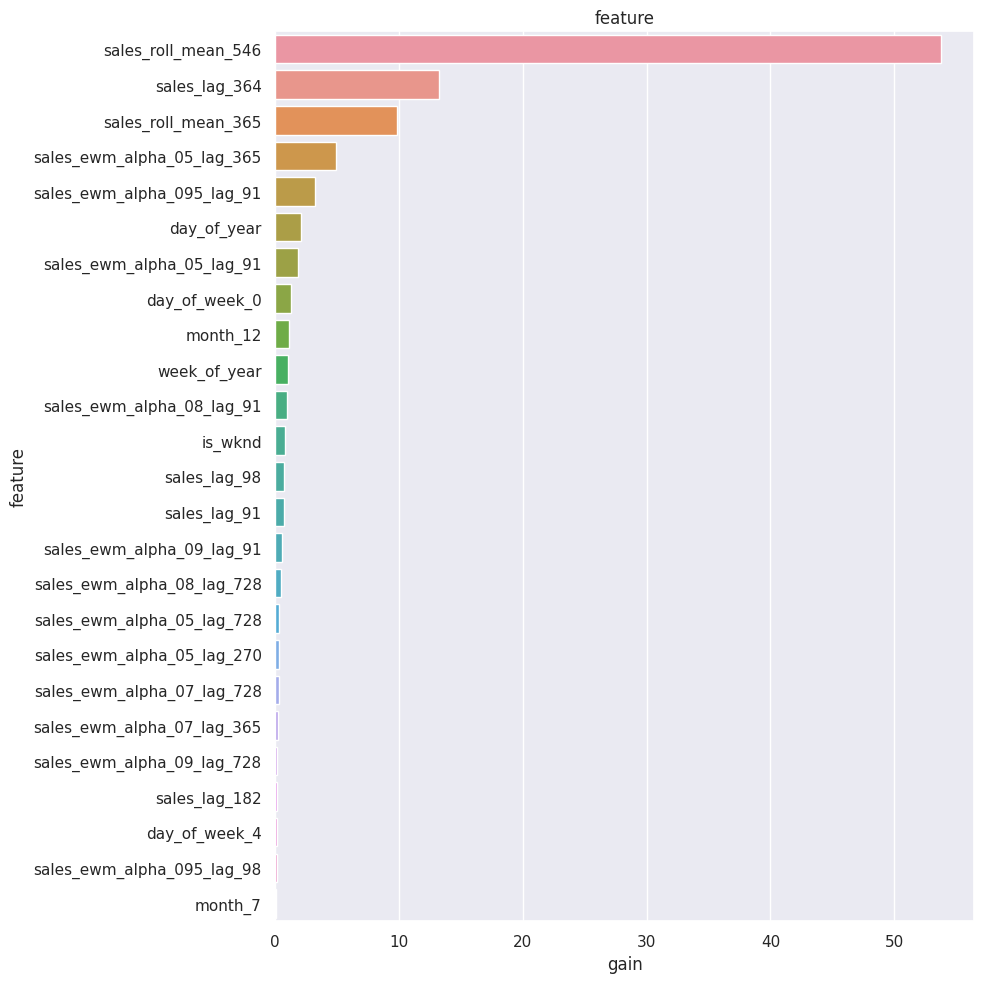

                        feature  split       gain
17          sales_roll_mean_546    908  53.750596
13                sales_lag_364   1220  13.208857
16          sales_roll_mean_365    585   9.825909
60   sales_ewm_alpha_05_lag_365    380   4.964628
18   sales_ewm_alpha_095_lag_91    107   3.199535
..                          ...    ...        ...
107                     item_35      0   0.000000
111                     item_39      0   0.000000
74                       item_2      0   0.000000
86                      item_14      0   0.000000
71                      store_9      0   0.000000

[142 rows x 3 columns]


111

In [15]:

########################
# Feature İmportance
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)


feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [16]:
########################
# Final Model
########################

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [17]:
########################
# Submission File
########################

test.head()

submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission_demand.csv", index=False)